# MixMatch Training for Binary Classification

In [13]:
import torch
import matplotlib.pyplot as plt
import os

In [14]:
import mixmatch
import data_utils
import data_pl_utils
import viz_utils
import models

In [15]:
import importlib
print(importlib.reload(mixmatch))
print(importlib.reload(data_pl_utils))
print(importlib.reload(data_utils))
print(importlib.reload(viz_utils))
print(importlib.reload(models))

<module 'mixmatch' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\mixmatch.py'>
<module 'data_pl_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_pl_utils.py'>
<module 'data_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_utils.py'>
<module 'viz_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\viz_utils.py'>
<module 'models' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\models.py'>


# Configuration

In [16]:
device = 'cuda'
# device = 'cpu'

In [17]:
PL_DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('../l3d_pn_dataset500PL'))

# 1. Setup Model

# Define the model (example using ResNet18)

In [18]:
model = models.PretrainedResNetForPN(
    src_dataset='ImageNet1k',
    arch='ResNet10',
    model_dir='.',
    n_trainable_layers=1,
    n_target_classes=2,  # Binary classification
    seed=42
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Trainable parameter count=1026 over 2 tensors in layers: output.


# 2. Prepare Data

# Create initial data loaders

In [19]:
train_loader, val_loader, test_loader = data_utils.make_data_loaders(
    root=PL_DATA_DIR,
    batch_size=32,
    n_samples_per_class_trainandvalid=125,
    frac_valid=0.2
)


splitname   0   1
 lp_train 100 100
 lp_valid  25  25
  lp_test 125 125


# Create MixMatch specific loaders (labeled and unlabeled splits)

# 3. Initialize MixMatch

In [20]:
mixmatch = mixmatch.MixMatch(
    model=model,
    num_augmentations=2,
    temperature=0.5,
    alpha=0.75,
    lambda_u=75,
    device=device
)

# 4. Train Model

In [21]:
# Define optimizer with only trainable parameters
optimizer = torch.optim.Adam(model.trainable_params.values(), lr=0.001)

model, history = mixmatch.train(
    tr_loader=train_loader,
    va_loader=val_loader,
    te_loader=test_loader,
    num_epochs=100,
    learning_rate=0.01,  # This will be used if optimizer is not provided
    save_path='best_mixmatch_model.pth',
    optimizer=optimizer  # Pass the custom optimizer
)


  1%|          | 1/101 [00:00<01:23,  1.20it/s, tr_loss=nan, va_loss=0.793, va_acc=50]c:\Users\josep\Code\School\L3D\Project\PL\mixmatch.py:186: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_mix
100%|██████████| 101/101 [02:07<00:00,  1.26s/it, tr_loss=4.08, va_loss=3.62, va_acc=50, batch_done=2]

Finished after epoch 100, best epoch=1
best va_xent 0.716


# 5. Visualize Results

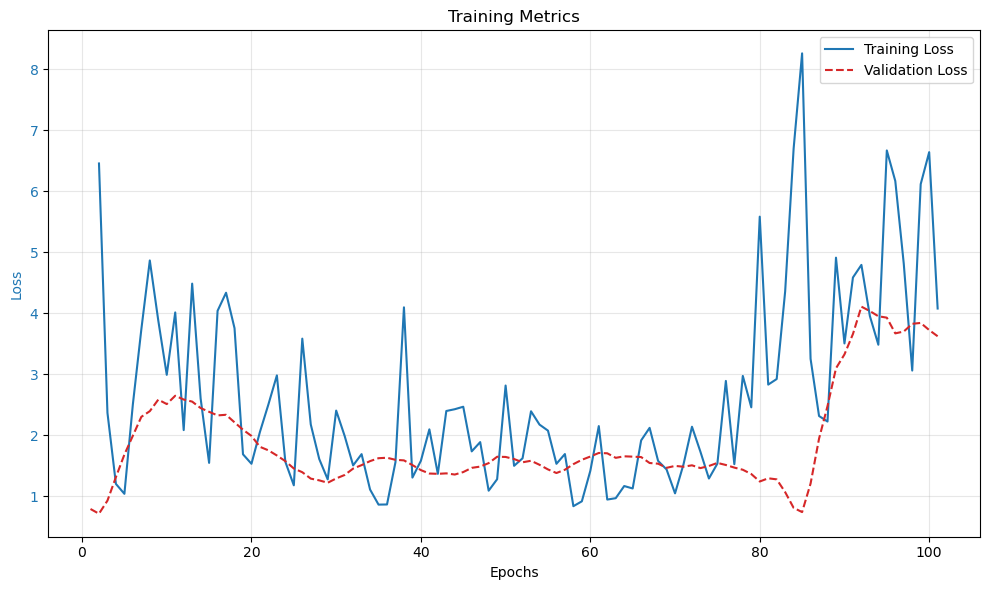

In [22]:
fig = viz_utils.plot_training_metrics(
    training_history=history,
)
plt.show()